In [1]:
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.WARN)
import ray
ray.init(log_to_driver=False)
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.random_circuit import random_circuits
from janusq.data_objects.backend import FullyConnectedBackend

from janusq.simulator.noisy_simulator import NoisySimulator
import random

from janusq.tools.ray_func import map

2024-04-15 03:06:09,855	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 66961408 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-04-15 03:06:09,993	INFO worker.py:1724 -- Started a local Ray instance.


# Noise Optimization Based on JanusQ-CT


**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

The accurate fidelity prediction enables JanusQ-CT to guide the noise optimization. In this notebook, we introduce two optimization strategies.

## Mapping

A typical compilation flow includes routing and scheduling. The routing pass transforms the circuit to satisfy the processor topology. Clearly, it inserts SWAP gates to change the qubit mapping, ensuring that all two-qubit gates can be implemented by the coupler of the processor. By precisely predicting the fidelity, QuCT can be integrated with existing compilers to find the routing solution with the best fidelity. 

For example, wecan use Janus-CT to guide the mapping of qiskit.

In [2]:
# build a simulator

n_qubits = 5
n_steps = 1
n_walks = 20
backend = FullyConnectedBackend(n_qubits)

circuits = random_circuits(backend, n_circuits=500, n_gate_list=[30, 50, 100], two_qubit_prob_list=[.4], reverse=True)
vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
vec_model.train(circuits, multi_process=False, remove_redundancy = False)

all_paths = vec_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = vec_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

100%|██████████| 501/501 [00:04<00:00, 104.23it/s]


In [3]:
# train a fidelity model
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=True)

fidelity_model = FidelityModel(vec_model)
fidelity_model.train((circuits, ground_truth_fidelities))

400it [00:00, 623920.27it/s]
101it [00:00, 545908.12it/s]


In [4]:
# generate a set of benchmarking circuits

from janusq.data_objects.algorithms import get_algs
from janusq.optimizations.scheduling.scheduling_ct import Scheduler
from janusq.optimizations.mapping.mapping_ct import Mapper
algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'ghz', 'grover']
benchmarking_circuits = get_algs(n_qubits, backend, algs)

We evaluate the mapping guided by JanusQ-CT model with the qiskit optimizer with level = 3.

In [5]:
from janusq.data_objects.backend import LinearBackend


mapper = Mapper(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = mapper.run(circuit, mapping_backend, return_candidates=False)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before mapping: ', baseline_fidelities[-1], 'after mapping: ', opt_fidelities[-1])

before mapping:  0.8322933616698449 after mapping:  0.8322441293645302
before mapping:  0.5885327581245511 after mapping:  0.39103071029283903
before mapping:  0.7760552314133228 after mapping:  0.6745903136071159
before mapping:  0.5833476691646966 after mapping:  0.5786318729330259
before mapping:  0.6649542614672598 after mapping:  0.7817944085682973
before mapping:  0.7355183450114785 after mapping:  0.790338687882546
before mapping:  0.03257843042598762 after mapping:  0.04238801140860788
before mapping:  0.7572329685895777 after mapping:  0.2701394685084738


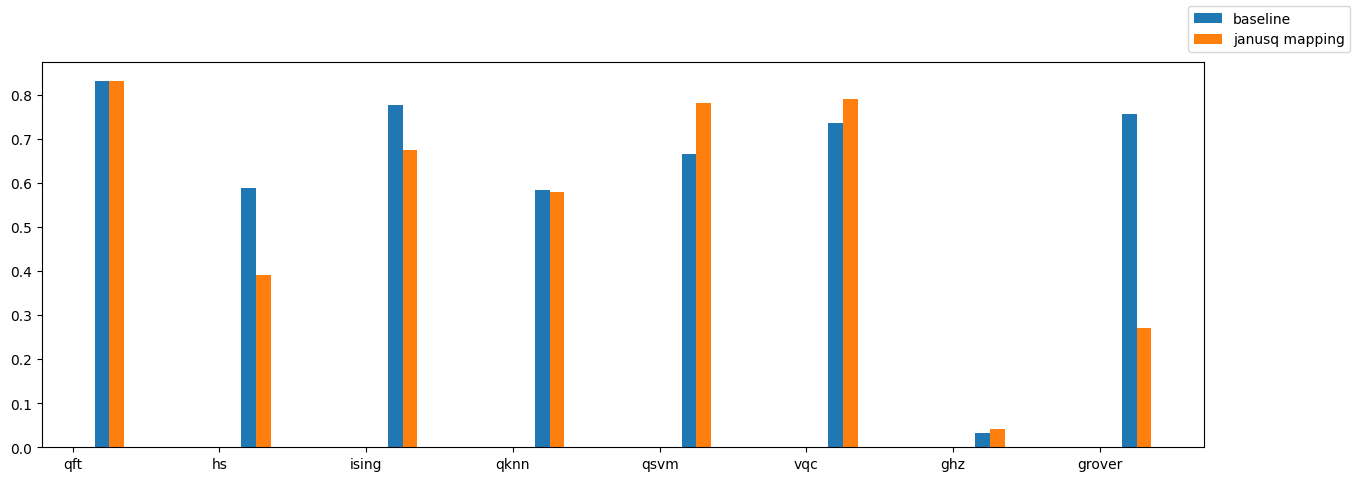

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))  
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq mapping')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()

## Scheduling

We can also use Janus-CT to guide the scheduling.

In [7]:
scheduler = Scheduler(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = scheduler.run(circuit, timeout=60)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before scheduling: ', baseline_fidelities[-1], 'after scheduling: ', opt_fidelities[-1])

before scheduling:  0.826010710460614 after scheduling:  0.7669839265676653
before scheduling:  0.6020079252543498 after scheduling:  0.512846906056753
before scheduling:  0.6684779675808471 after scheduling:  0.7508043028513363
before scheduling:  0.7271505686660833 after scheduling:  0.5079828724730381
before scheduling:  0.7861623909199362 after scheduling:  0.7685734599070344
before scheduling:  0.7244812459597059 after scheduling:  0.7503905886788945
before scheduling:  0.05535610171542282 after scheduling:  0.2520792551664671
before scheduling:  0.7792155502825151 after scheduling:  0.7504847743355849


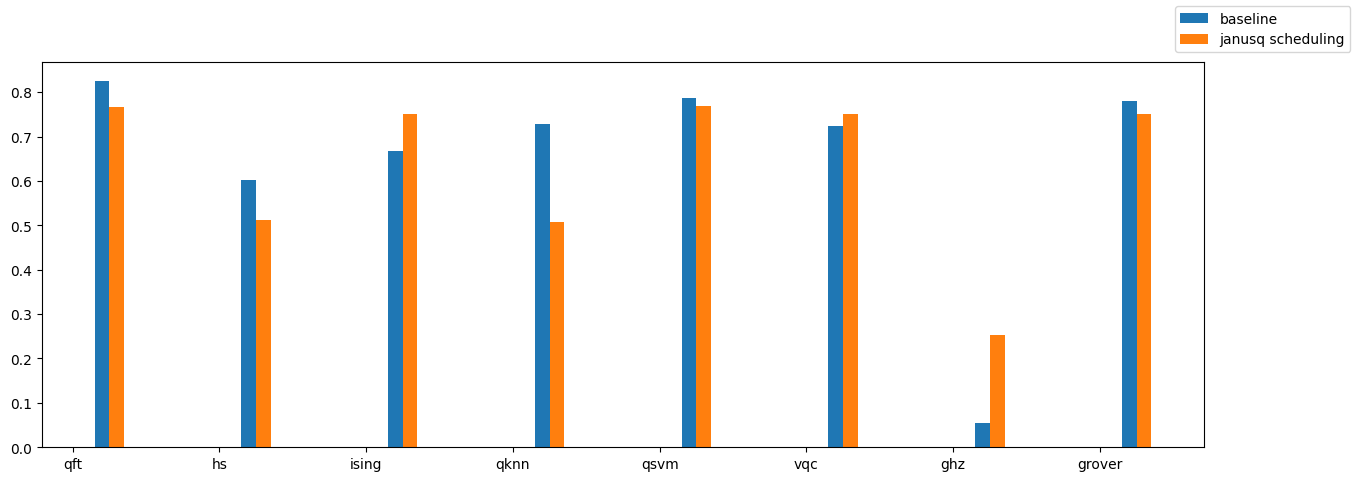

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq scheduling')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()